# Winning in the Big Leagues

In [ ]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline 
import seaborn as sns
sns.set_style('ticks')
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix
import itertools
import xgboost as xgb
from xgboost import plot_importance
import warnings
from datetime import datetime, timedelta
from fbprophet import Prophet
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Read in CSV File
df = pd.read_csv('file:///Users/chrisfiorentine/Downloads/game_logs.csv')

In [3]:
# Use only years after 2015 
df = df[df['date'] > 20150000]

In [4]:
# Creating Run Diferential
df['Run_dif'] = df.h_score - df.v_score

In [5]:
# Creating Wins
def wins(rd):
    if rd > 0:
        return 1
    if rd < 0:
        return 0

In [6]:
df['Win'] = df['Run_dif'].apply(wins)

In [7]:
# Drop not needed columns
drop_columns = ['v_line_score','h_line_score','1b_umpire_id', '1b_umpire_name','2b_umpire_id','2b_umpire_name',
                   '3b_umpire_id','3b_umpire_name','lf_umpire_id','lf_umpire_name','rf_umpire_id','rf_umpire_name',
                   'winning_rbi_batter_id','winning_rbi_batter_id_name','winning_pitcher_id',
                   'winning_pitcher_name','losing_pitcher_id','losing_pitcher_name','saving_pitcher_id',
                   'saving_pitcher_name','additional_info','acquisition_info','number_of_game','day_of_week',
                    'v_league','v_game_number','h_league','h_game_number','length_outs','day_night',
                   'completion','forefeit','protest','park_id','length_minutes','v_starting_pitcher_name','v_player_1_id','v_player_1_name',
                     'v_player_1_def_pos','v_player_2_id','v_player_3_id','v_player_4_id','v_player_5_id',
                     'v_player_6_id','v_player_7_id','v_player_8_id','v_player_9_id','v_player_2_name',
                     'v_player_3_name','v_player_4_name','v_player_5_name','v_player_6_name','v_player_7_name',
                     'v_player_8_name','v_player_9_name','v_player_2_def_pos','v_player_3_def_pos',
                     'v_player_4_def_pos','v_player_5_def_pos','v_player_6_def_pos','v_player_7_def_pos',
                     'v_player_8_def_pos','v_player_9_def_pos','h_player_2_def_pos', 'h_player_3_id', 'h_player_3_name',
       'h_player_3_def_pos', 'h_player_4_id', 'h_player_4_name',
       'h_player_4_def_pos', 'h_player_5_id', 'h_player_5_name',
       'h_player_5_def_pos', 'h_player_6_id', 'h_player_6_name',
       'h_player_6_def_pos', 'h_player_7_id', 'h_player_7_name',
       'h_player_7_def_pos', 'h_player_8_id', 'h_player_8_name',
       'h_player_8_def_pos', 'h_player_9_id', 'h_player_9_name',
       'h_player_9_def_pos','hp_umpire_id', 'hp_umpire_name',
       'h_manager_id', 'h_manager_name',
       'h_starting_pitcher_name', 'h_player_1_id', 'h_player_1_name','v_manager_id', 'v_manager_name',
       'h_player_1_def_pos', 'h_player_2_id', 'h_player_2_name','v_starting_pitcher_id','h_starting_pitcher_id']

In [8]:
df = df.drop(columns = drop_columns)

In [9]:
df.dropna(inplace = True)

## Feature Engineering

In [10]:
df['h_xbh'] = df.h_doubles + df.h_triples + df.h_homeruns

In [11]:
df = df.drop(columns = ['h_doubles','h_triples','h_homeruns'])

In [12]:
df['v_xbh'] = df.v_doubles + df.v_triples + df.v_homeruns

In [13]:
df = df.drop(columns = ['v_doubles','v_triples','v_homeruns'])

In [14]:
df['v_pitcher_allowed_on_base'] = df.h_walks + df['h_intentional walks'] + df.h_hit_by_pitch

In [15]:
df['h_pitcher_allowed_on_base'] = df.v_walks + df['v_intentional walks'] + df.v_hit_by_pitch

In [16]:
df = df.drop(columns = ['v_walks','v_intentional walks','h_hit_by_pitch'])

In [17]:
df = df.drop(columns = ['h_walks','h_intentional walks','v_hit_by_pitch'])

In [18]:
df['v_advanced_runner'] = df.v_sacrifice_hits + df.v_sacrifice_flies +df.v_stolen_bases

In [19]:
df['h_advanced_runner'] = df.h_sacrifice_hits + df.h_sacrifice_flies +df.h_stolen_bases

In [20]:
df = df.drop(columns = ['h_sacrifice_hits','h_sacrifice_flies','h_stolen_bases'])

In [21]:
df = df.drop(columns = ['v_sacrifice_hits','v_sacrifice_flies','v_stolen_bases'])

In [22]:
df['v_pitcher_allowed_runner_advance'] = df.v_wild_pitches + df.v_balks + df.v_passed_balls

In [23]:
df['h_pitcher_allowed_runner_advance'] = df.h_wild_pitches + df.h_balks + df.h_passed_balls

In [24]:
df = df.drop(columns = ['v_wild_pitches','v_balks','v_passed_balls','h_wild_pitches','h_balks','h_passed_balls'])

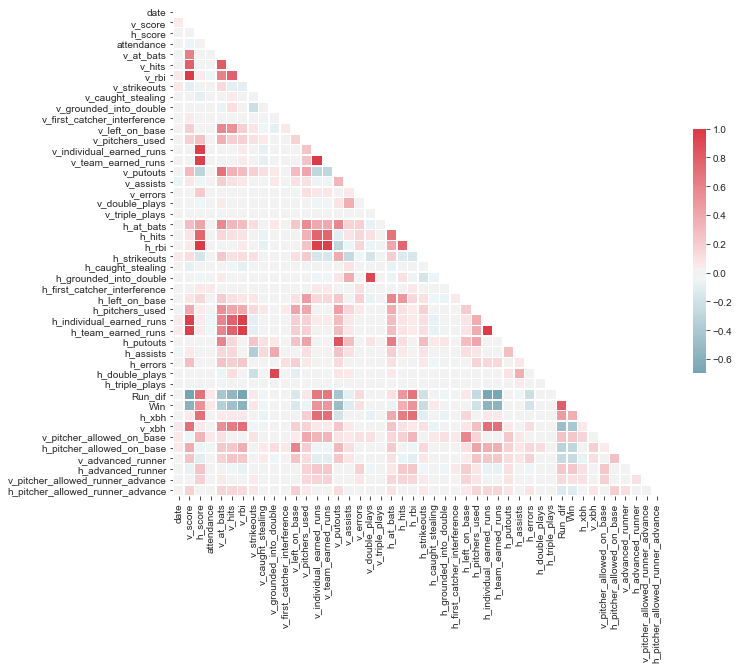

In [25]:
# Compute the correlation matrix
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [110]:
# Read in second dataset
df2 = pd.read_csv('file:///Users/chrisfiorentine/Downloads/datasets_3217_5288_baseball.csv')

## EDA

In [30]:
df2 = df2[df2['Year'] > 1998]

(array([ 1.,  8., 23., 81., 77., 82., 87., 53.,  7.,  1.]),
 array([ 43. ,  50.3,  57.6,  64.9,  72.2,  79.5,  86.8,  94.1, 101.4,
        108.7, 116. ]),
 <a list of 10 Patch objects>)

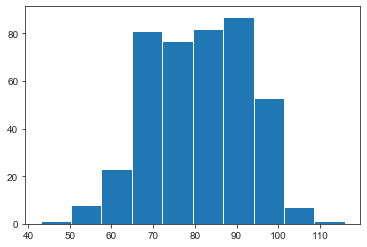

In [31]:
plt.hist(df2['W'])

In [32]:
playoffs_df = df2.loc[df2['Playoffs'] == 1]

In [33]:
playoffs_df['RA'].describe()

count    114.000000
mean     697.438596
std       63.508627
min      529.000000
25%      650.250000
50%      689.500000
75%      733.500000
max      860.000000
Name: RA, dtype: float64

In [34]:
playoffs_df['RS'].describe()

count     114.000000
mean      812.850877
std        74.074494
min       669.000000
25%       761.250000
50%       804.500000
75%       865.250000
max      1009.000000
Name: RS, dtype: float64

In [35]:
playoffs_df.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0,114.000000,114.000000,114.000000,114.000000,114.000000
mean,2005.614035,812.850877,697.438596,94.482456,0.341184,0.434061,0.269044,1.0,3.649123,3.157895,161.973684,0.321412,0.403833
std,4.103762,74.074494,63.508627,4.892169,0.013191,0.020652,0.010876,0.0,1.838538,1.077353,0.363380,0.011056,0.019147
min,1999.000000,669.000000,529.000000,82.000000,0.310000,0.389000,0.238000,1.0,1.000000,1.000000,161.000000,0.296000,0.361000
25%,2002.000000,761.250000,650.250000,91.000000,0.332000,0.420250,0.262250,1.0,2.000000,3.000000,162.000000,0.314000,0.392000
50%,2006.000000,804.500000,689.500000,95.000000,0.341000,0.433500,0.269000,1.0,4.000000,4.000000,162.000000,0.321000,0.403500
75%,2009.000000,865.250000,733.500000,97.000000,0.350000,0.448000,0.277000,1.0,5.000000,4.000000,162.000000,0.328000,0.417000
max,2012.000000,1009.000000,860.000000,116.000000,0.373000,0.491000,0.293000,1.0,7.000000,5.000000,163.000000,0.348000,0.459000


In [36]:
df2['RD'] = df2['RS'] - df2['RA']

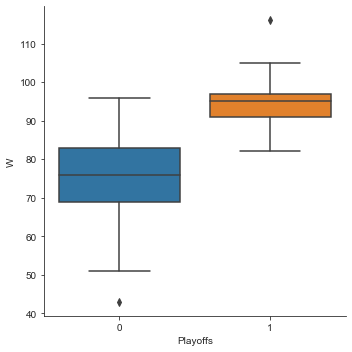

In [37]:
sns.catplot(data = df2, x = 'Playoffs', y = 'W', kind = 'box')

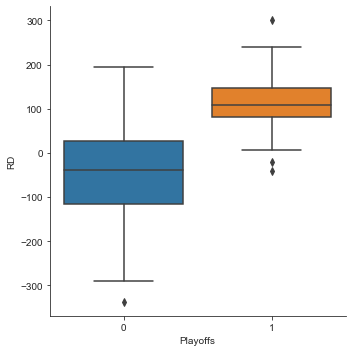

In [38]:
sns.catplot(data = df2, x = 'Playoffs', y = 'RD', kind = 'box')

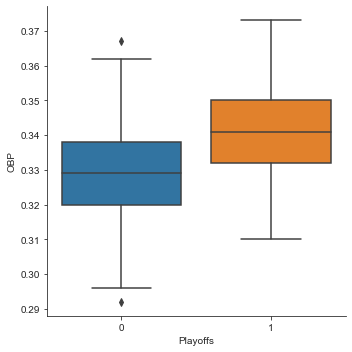

In [39]:
sns.catplot(data = df2, x = 'Playoffs', y = 'OBP', kind = 'box')

## Modeling

In [40]:
df2_features = df2.drop(columns = ['League', 'RankSeason','G','RankPlayoffs','Team','Playoffs','W','Year','RS','RA'])

In [41]:
target = df2['W']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df2_features, target,test_size=.25,random_state=30)

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns= df2_features.columns)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns = df2_features.columns)

In [45]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 3.8324114578275443


In [47]:
y_test_pred = lm.predict(X_test)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print('Test Root Mean Squared Error:' , test_rmse)

Test Root Mean Squared Error: 3.9031019838651986


In [48]:
target2 = df2['Playoffs']

In [49]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2_features, target2,test_size=.25,random_state=25)

In [50]:
lr = LogisticRegression(solver='liblinear',class_weight='balanced')

lr.fit(X_train2, y_train2)

y_pred_test2 = lr.predict(X_test2)


print('Test Accuracy score: ', accuracy_score(y_test2, y_pred_test2))


print('Test F1 score: ', f1_score(y_test2, y_pred_test2))

Test Accuracy score:  0.819047619047619
Test F1 score:  0.7323943661971831


In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[60 15]
 [ 4 26]]


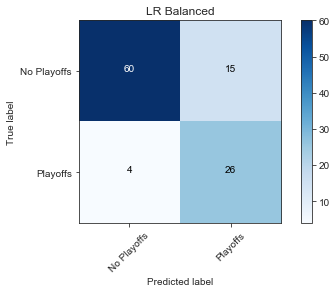

In [53]:
cm = confusion_matrix(y_test2,y_pred_test2)
classes = ['No Playoffs', 'Playoffs']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='LR Balanced',
                          cmap=plt.cm.Blues)

In [54]:
lr_coef01 = pd.DataFrame(data=lr.coef_).T
lr_coef01 = lr_coef01.set_index(X_train2.columns)
lr_coef01 = lr_coef01.sort_values(by = 0, ascending = False).T

In [56]:
lr_coef01.T.head(5)

,0
RD,0.037132
BA,-0.314431
OBP,-0.390766
OOBP,-0.400931
OSLG,-0.492859


## Feature Engineering

In [57]:
train = df.head(3993)
last_30_days = train.tail(381)

In [59]:
test = df.tail(861)

In [60]:
home_last30_mean = last_30_days.groupby('h_name').mean()

In [61]:
home_last30_mean = home_last30_mean.reset_index()

In [62]:
away_last30 = last_30_days.copy()

In [63]:
away_last30['Run_dif'] = -away_last30['Run_dif']

In [64]:
away_last30['Win'] = away_last30['Run_dif'].apply(wins)

In [65]:
away_last30_mean = away_last30.groupby('v_name').mean()

In [66]:
away_last30_mean = away_last30_mean.reset_index()

In [78]:
new_df = pd.read_csv('new_df') # DataFrame from workbook notebook

## Modeling

In [70]:
# Function to fit a model and predict outcomes

def fit_predict_classes(model, x_train, y_train, x_test,y_test):
    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    print('Training Accuracy score: ', accuracy_score(y_train, train_predictions))

    print('Training F1 score: ', f1_score(y_train, train_predictions))
    
    print('Training ROC AUC score: ', roc_auc_score(y_train, train_predictions))
    
    print()

    print('Testing Accuracy score: ', accuracy_score(y_test, test_predictions))

    print('Testing F1 score: ', f1_score(y_test, test_predictions))
    
    print('Testing ROC AUC score: ', roc_auc_score(y_test, test_predictions))

In [71]:
# Instantiating Logistic Regression Classification
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced') 

In [72]:
# Instantiate Random Forest Classifier
rfc = RandomForestClassifier()

In [73]:
# Instantiate XGBoost 
xgb = xgb_est = xgb.XGBClassifier(objective = 'binary:logistic')

In [74]:
df_2016 = pd.read_csv('df3') # DataFrame from functions notebook

In [75]:
df_2016 = df_2016.drop(columns = ['attendance','v_at_bats','v_hits','v_rbi','v_strikeouts',
                            'v_caught_stealing',
       'v_grounded_into_double', 'v_first_catcher_interference',
       'v_left_on_base', 'v_pitchers_used', 'v_individual_earned_runs',
       'v_team_earned_runs', 'v_putouts', 'v_assists', 'v_errors',
       'v_double_plays', 'v_triple_plays', 'h_at_bats', 'h_hits', 'h_rbi',
       'h_strikeouts', 'h_caught_stealing', 'h_grounded_into_double',
       'h_first_catcher_interference', 'h_left_on_base', 'h_pitchers_used',
       'h_individual_earned_runs', 'h_team_earned_runs', 'h_putouts',
       'h_assists', 'h_errors', 'h_double_plays', 'h_triple_plays','h_xbh', 'v_xbh',
       'v_pitcher_allowed_on_base', 'h_pitcher_allowed_on_base',
       'v_advanced_runner', 'h_advanced_runner',
       'v_pitcher_allowed_runner_advance', 'h_pitcher_allowed_runner_advance'])

In [79]:
full_df = df_2016.merge(new_df)

In [80]:
full_df = full_df.drop_duplicates()

In [81]:
train_df2 = full_df[full_df['date'] > 20160000]
train_df2 = train_df2.head(1565)

In [82]:
test_df2 = full_df.loc[3995:4418]

In [88]:
X_train_final = train_df2.drop(columns = ['date', 'Run_dif', 'Win','v_score','h_score','v_name','h_name'])

In [89]:
y_train_final = train_df2.Win

In [90]:
X_test_final = test_df2.drop(columns = ['date', 'Run_dif', 'Win','v_score','h_score','v_name','h_name'])

In [91]:
y_test_final = test_df2.Win

In [92]:
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_final =pd.DataFrame(data=scaler.transform(X_train_final), columns= X_train_final.columns)
X_test_final =pd.DataFrame(data=scaler.transform(X_test_final), columns = X_train_final.columns)

In [93]:
# Fit Predict Log Reg
fit_predict_classes(log_reg, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.6121405750798722
Training F1 score:  0.632344033918837
Training ROC AUC score:  0.6113601066467033

Testing Accuracy score:  0.6344339622641509
Testing F1 score:  0.651685393258427
Testing ROC AUC score:  0.6345426044116


In [94]:
# Fit Predict Random Forest
fit_predict_classes(rfc, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.7680511182108626
Training F1 score:  0.7888307155322862
Training ROC AUC score:  0.7649339860847066

Testing Accuracy score:  0.7783018867924528
Testing F1 score:  0.8008474576271187
Testing ROC AUC score:  0.7742022169969768


In [95]:
# Fit Predict XGBoost
fit_predict_classes(xgb, X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.7680511182108626
Training F1 score:  0.7873462214411249
Training ROC AUC score:  0.7654905321499752

Testing Accuracy score:  0.7735849056603774
Testing F1 score:  0.7948717948717948
Testing ROC AUC score:  0.770216101220468


In [96]:
param_dist2 = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.01],
              'max_depth': [3, 4, 6, 8],
              'colsample_bytree': [0.5,0.4],
              'min_child_weight': [1,  3]
             }

In [99]:
xgb_gs = GridSearchCV(
    estimator = xgb_est,
    param_grid = param_dist2, 
    scoring='accuracy',
    #n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [100]:
xgb_gs.fit(X_train_final,y_train_final)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  3.5min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method=None,
                                     

In [101]:
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)
print(xgb_gs.best_estimator_)

0.5514376996805112
{'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)


In [102]:
fit_predict_classes(xgb_gs.best_estimator_,X_train_final, y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.6466453674121406
Training F1 score:  0.6936288088642659
Training ROC AUC score:  0.6389033908266761

Testing Accuracy score:  0.6768867924528302
Testing F1 score:  0.7209775967413443
Testing ROC AUC score:  0.668514164147352


In [103]:
xgb_pred = xgb.predict(X_test_final)

Confusion Matrix, without normalization
[[142  53]
 [ 43 186]]


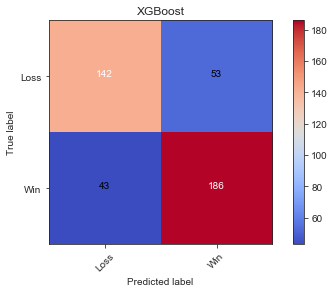

In [105]:
cm = confusion_matrix(y_test_final,xgb_pred)
classes = ['Loss', 'Win']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='XGBoost',
                          cmap=plt.cm.coolwarm)

In [106]:
#Fit Predict Dummy Classifier
fit_predict_classes(DummyClassifier(),X_train_final,y_train_final,X_test_final,y_test_final)

Training Accuracy score:  0.5150159744408945
Training F1 score:  0.5380401704199635
Training ROC AUC score:  0.5140975252579977

Testing Accuracy score:  0.4882075471698113
Testing F1 score:  0.5412262156448203
Testing ROC AUC score:  0.4820400850968537


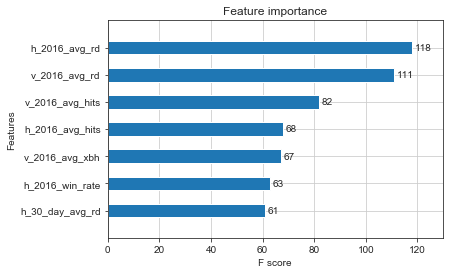

In [107]:
plot_importance(xgb, max_num_features=7,height = 0.5)

In [108]:
xgb_features = xgb.get_booster().get_fscore()

In [109]:
pd.DataFrame.from_dict(xgb_features, orient = 'index').sort_values(by = 0, ascending = False).head(10)

,0
h_2016_avg_rd,118
v_2016_avg_rd,111
v_2016_avg_hits,82
h_2016_avg_hits,68
v_2016_avg_xbh,67
h_2016_win_rate,63
h_30_day_avg_rd,61
h_30_day_avg_allowed_on_base,58
h_2016_avg_on_base_by_pitcher,57
v_2016_avg_attendance,55


## Conclusion 

XGBoost and Random Forest had the best models at 77% accuracy. 
Most important features are Run Dif, Hits, Walks, and scoring when there are runners on base. 